## Predição de Preços de Hotéis

Nosso objetivo é prever os preços de hotéis a partir de alguns dados sobre os hotéis, como a data e algumas características do hotel.

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve1
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from tpot import TPOTRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import shap

df = pd.read_csv('processed-dataset.csv')

df.drop(columns=['Unnamed: 0'], inplace=True)
df['checkin'] = pd.to_datetime(df['checkin'])
df['year'] = df['checkin'].dt.year
df['month'] = df['checkin'].dt.month
df['week'] = df['checkin'].dt.isocalendar().week
df_test = df[((df['checkin'].dt.month > 6) & (df['checkin'].dt.year == 2025))]
df = df[~((df['checkin'].dt.month > 6) & (df['checkin'].dt.year == 2025))]
df[df['month'] == 6].head()


c:\Python312\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


hotel  cidade  preço  \
3895                                         Park Hotel  Recife   2279   
3896  Veja o mar no silêncio do centro! Hospede-se n...  Recife    428   
3897  Lindo APT Cinza à 50m do mar - Praia de Boa Vi...  Recife    838   
3898                             Hotel Fit transamérica  Recife   1021   
3899                            Transamerica Fit Recife  Recife   2264   

        checkin    checkout  dist_centro  avaliacao  qtnd_avaliacoes  \
3895 2025-06-01  2025-06-08          8.6        8.5           5064.0   
3896 2025-06-01  2025-06-08          0.2        8.3              3.0   
3897 2025-06-01  2025-06-08          5.8       10.0              1.0   
3898 2025-06-01  2025-06-08          7.0        9.3              4.0   
3899 2025-06-01  2025-06-08          7.0        8.3           5177.0   

     data_extracao  mediana_preco  tem_feriado nome_feriado  mes_checkin  \
3895      2024-6-6         2279.0        False                         6   
3896      2024-6-6          428.0        False                         6   
3897      2024-6-6          838.0        False                         6   
3898      2024-6-6         1021.0        False                         6   
3899      2024-6-6         2264.0        False                         6   

      log_price price_category   season  norm_price  year  month  week  
3895   3.357744           Caro  Inverno    0.157948  2025      6    22  
3896   2.631444      Econômico  Inverno    0.012567  2025      6    22  
3897   2.923244      Econômico  Inverno    0.044769  2025      6    22  
3898   3.009026      Econômico  Inverno    0.059142  2025      6    22  
3899   3.354876           Caro  Inverno    0.156770  2025      6    22

Vamos agora dividir os dados em Teste e Treino. Como só temos 14 meses de dados (julho de 2024 até agosto 2025), foi interessante separar o período de 1 ano para o conjunto de treinamento, já que a nossa intenção é que os algoritmos de machine learning consigam entender e aprender sobre todos os meses.

In [2]:
# Divisão dos dados
df = pd.get_dummies(df, columns=['hotel', 'season', 'nome_feriado', 'tem_feriado'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['hotel', 'season', 'nome_feriado', 'tem_feriado'], drop_first=True)

# Reindexar df_test para ter as mesmas colunas que df
df_test = df_test.reindex(columns=df.columns, fill_value=0)

X_train = df.drop(['preço', 'checkin', 'cidade', 'checkout', 'data_extracao', 'log_price', 'norm_price', 'avaliacao', 'qtnd_avaliacoes', 'price_category', 'avaliacao'], axis=1)
y_train = df['preço']

X_test = df_test.drop(['preço', 'checkin', 'cidade', 'checkout', 'data_extracao', 'log_price', 'norm_price', 'avaliacao', 'qtnd_avaliacoes', 'price_category', 'avaliacao'], axis=1)
y_test = df_test['preço']


Escolhemos 4 algoritmos para criar um modelo a partir dos nossos dados. São eles:
- Linear Regression
- Random Forest
- CatBoost
- XGBoost

Vamos então aplicar eles a seguir com a abordagem de cross-validation com a utilização de hiperparâmetros para melhorar o desempenho dos algoritmos e plotar os resultados para comparar os melhores desempenhos deles.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for LinearRegression: {}
LinearRegression Test RMSE: 248.73423082054984
LinearRegression Test MAE: 154.71160457453624
LinearRegression Test R2: 0.9270631451515987
LinearRegression Train RMSE: 422.43004021879455
LinearRegression Train MAE: 197.70660561624007
LinearRegression Train R2: 0.8494286639980779


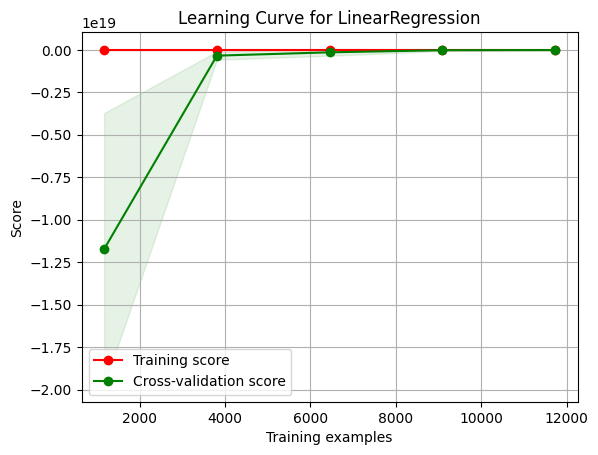

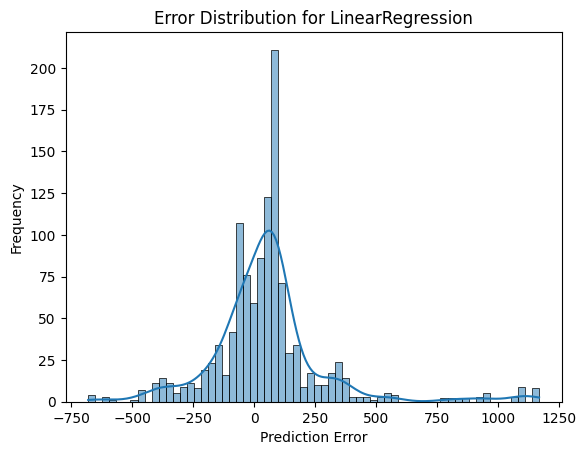

Feature importance not available for LinearRegression
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
RandomForest Test RMSE: 303.8322758508268
RandomForest Test MAE: 137.5807086140934
RandomForest Test R2: 0.8911712273453243
RandomForest Train RMSE: 125.79693392921621
RandomForest Train MAE: 37.54755185472804
RandomForest Train R2: 0.9866471851551516


<Figure size 640x480 with 0 Axes>

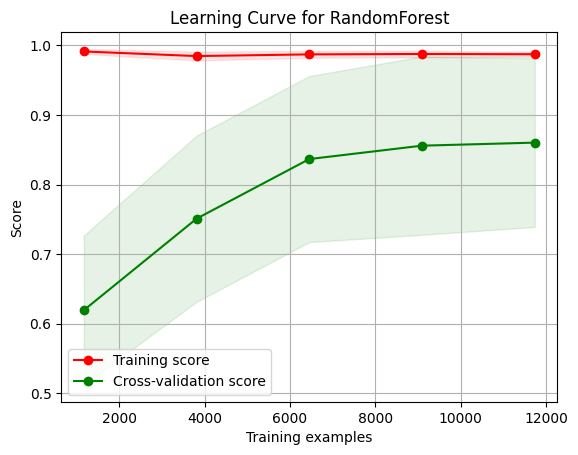

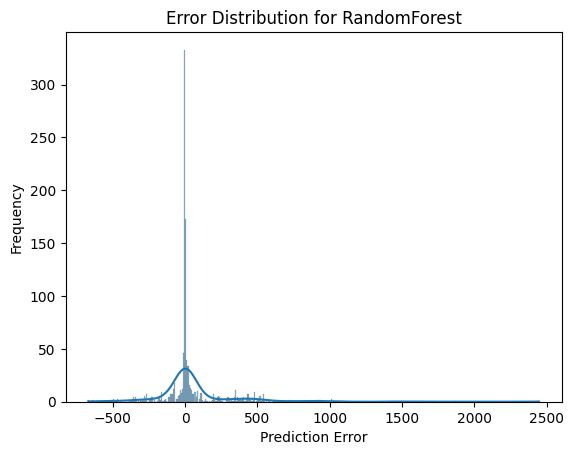

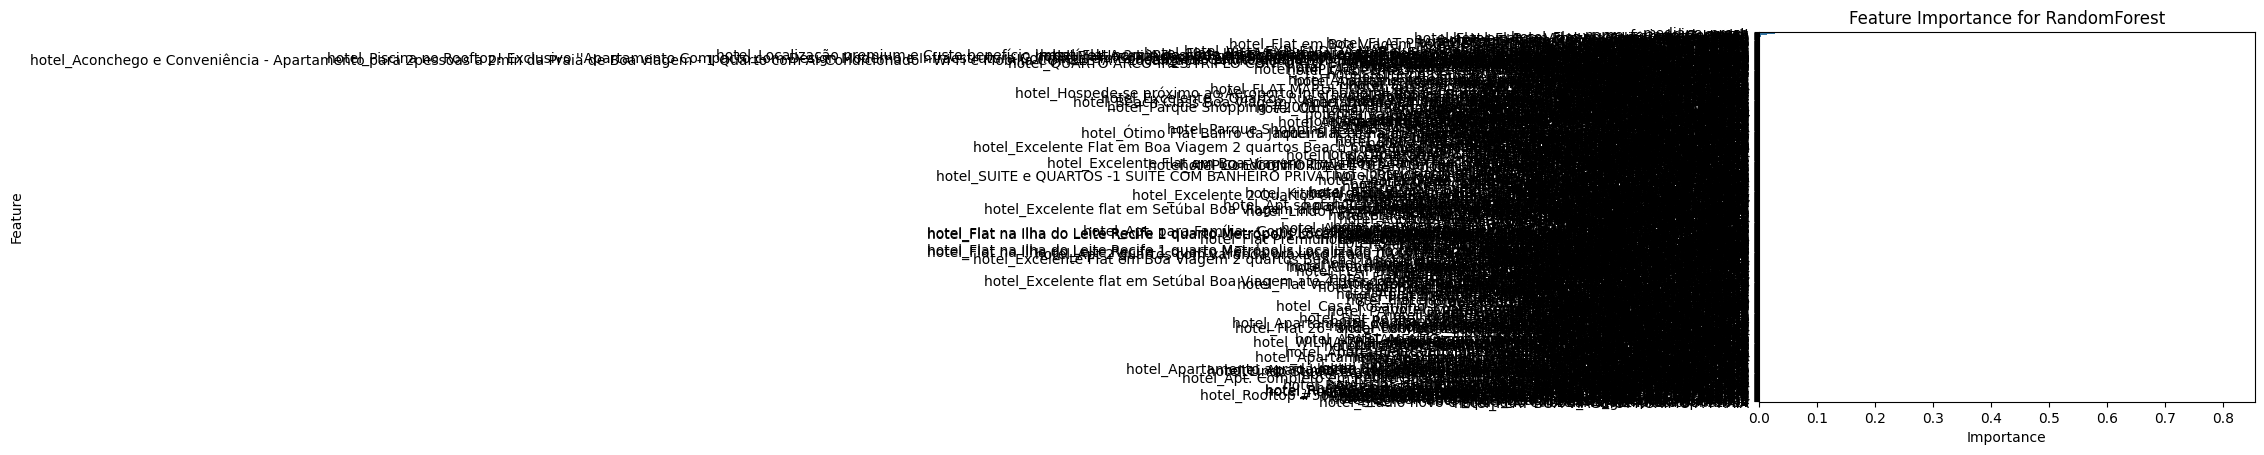

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for CatBoost: {'depth': 10, 'iterations': 1500, 'learning_rate': 0.1}
CatBoost Test RMSE: 287.5937789596046
CatBoost Test MAE: 140.21654449669384
CatBoost Test R2: 0.9024932024996225
CatBoost Train RMSE: 102.8369016513904
CatBoost Train MAE: 64.02906432569729
CatBoost Train R2: 0.9910765934150771


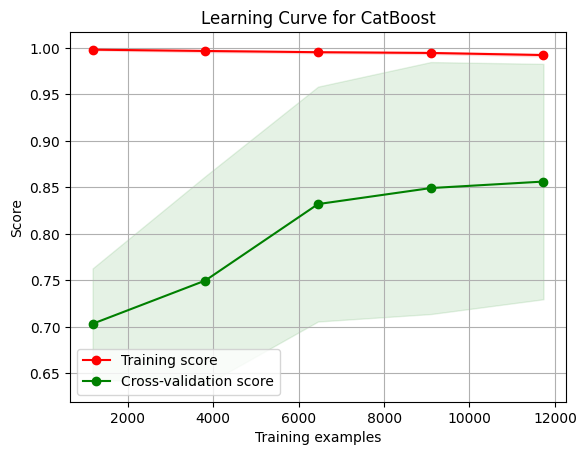

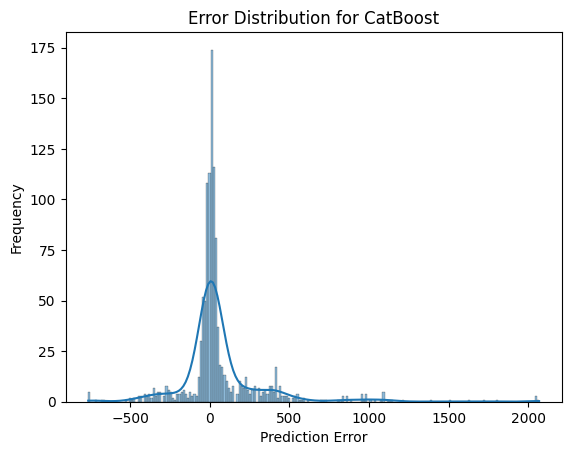

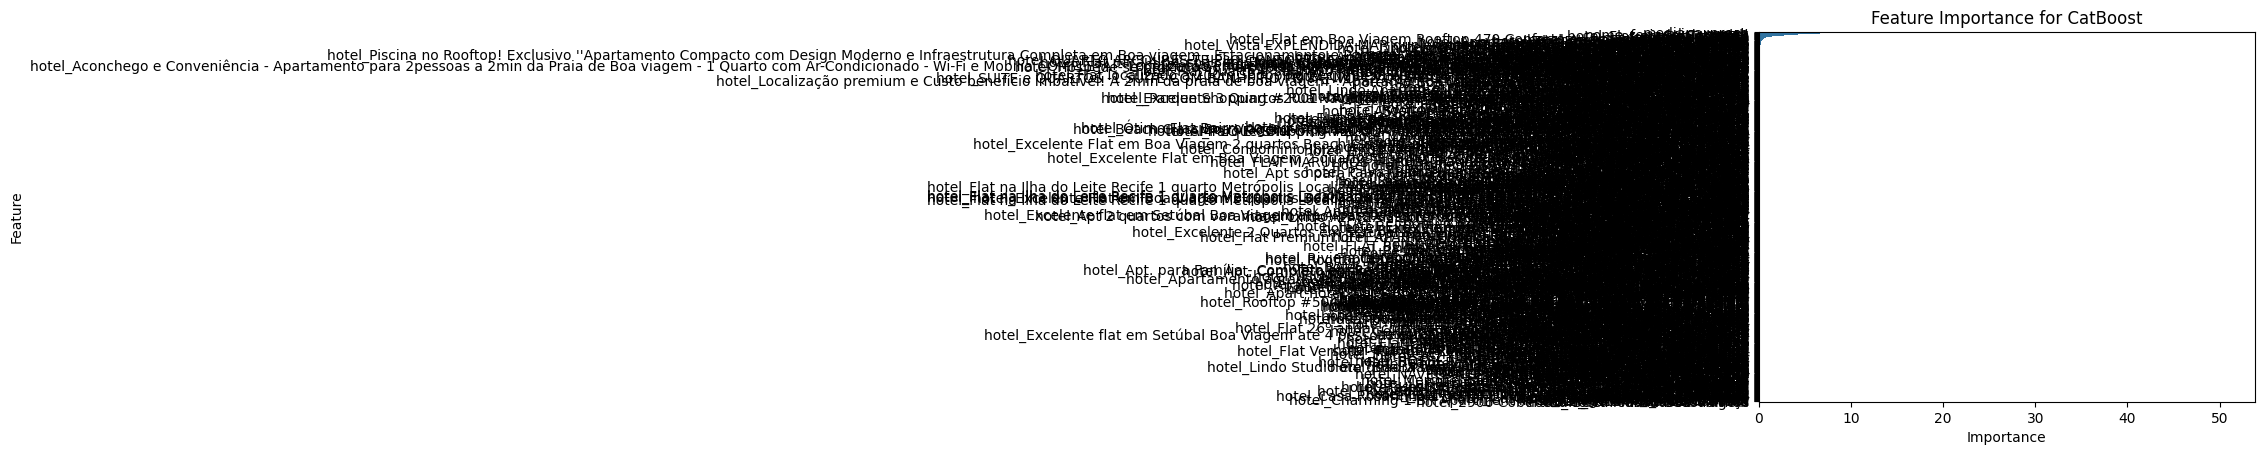

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
XGBoost Test RMSE: 313.4368455809435
XGBoost Test MAE: 140.842267349997
XGBoost Test R2: 0.8841820359230042
XGBoost Train RMSE: 212.12776298685682
XGBoost Train MAE: 111.95737282548887
XGBoost Train R2: 0.9620311260223389


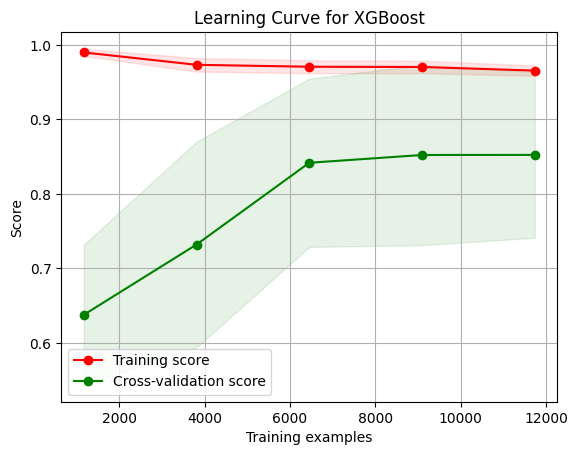

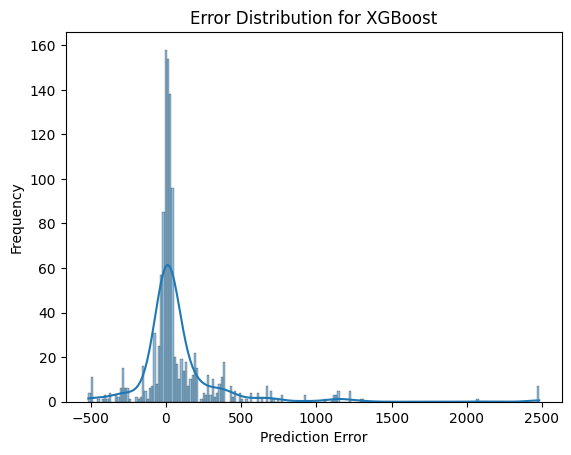

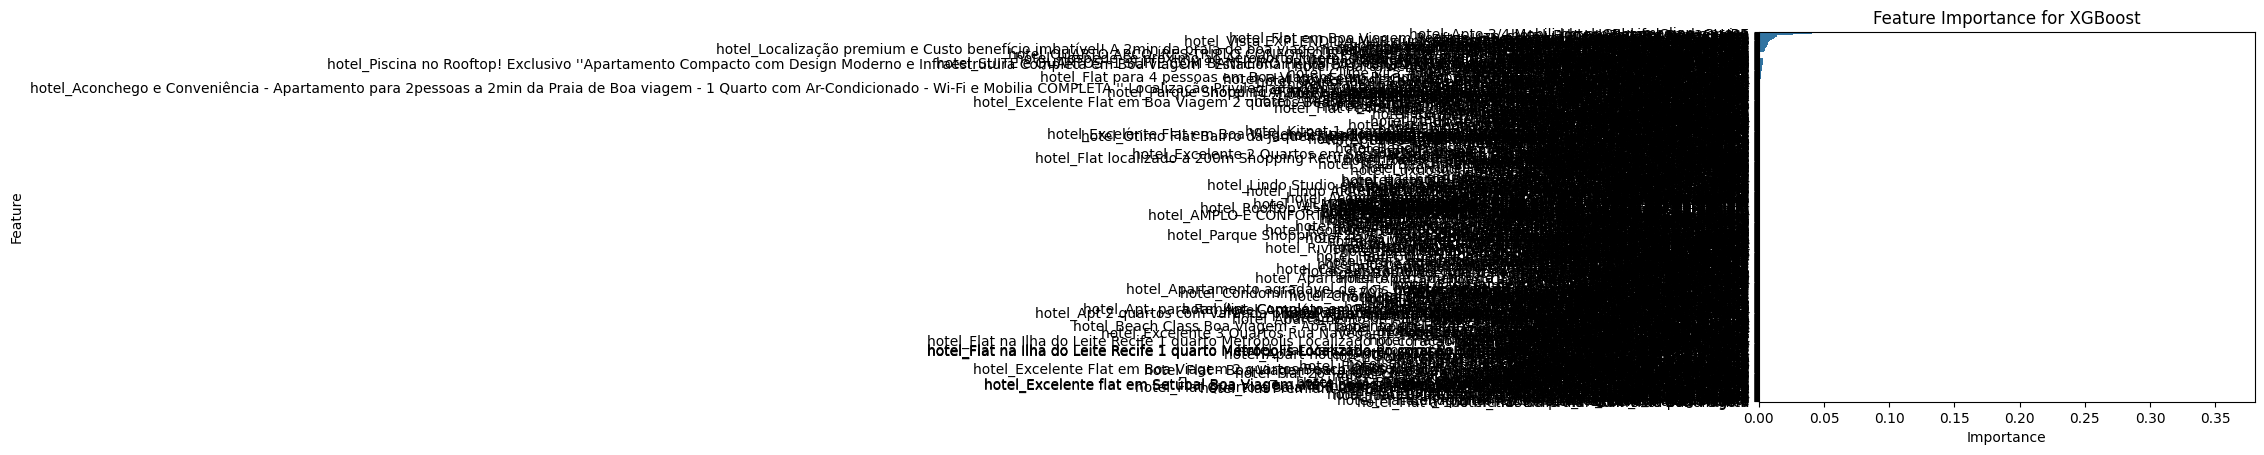

In [144]:
# Configuração do MLflow
experiment_name = "Price_Prediction_Experiment"
mlflow.set_experiment(experiment_name)

# Definição das funções de treino e log
def train_and_evaluate(model, param_grid, model_name):
    with mlflow.start_run(run_name=model_name):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        
        # Avaliação do modelo no conjunto de teste
        y_pred_test = best_model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Avaliação do modelo no conjunto de treinamento
        y_pred_train = best_model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        print(f'Best Parameters for {model_name}: {grid_search.best_params_}')
        print(f'{model_name} Test RMSE: {rmse_test}')
        print(f'{model_name} Test MAE: {mae_test}')
        print(f'{model_name} Test R2: {r2_test}')
        print(f'{model_name} Train RMSE: {rmse_train}')
        print(f'{model_name} Train MAE: {mae_train}')
        print(f'{model_name} Train R2: {r2_train}')
        
        # Logando métricas no MLflow
        mlflow.log_param("Best Parameters", grid_search.best_params_)
        mlflow.log_metric("Test RMSE", rmse_test)
        mlflow.log_metric("Test MAE", mae_test)
        mlflow.log_metric("Test R2", r2_test)
        mlflow.log_metric("Train RMSE", rmse_train)
        mlflow.log_metric("Train MAE", mae_train)
        mlflow.log_metric("Train R2", r2_train)
        
        # Logando o melhor modelo no MLflow
        mlflow.sklearn.log_model(best_model, model_name)

        # Plotando curva de aprendizado
        plot_learning_curve(best_model, f'Learning Curve for {model_name}', X_train, y_train, cv=5)
        
        # Plotando distribuição de erros de predição
        y_pred = best_model.predict(X_test)
        plot_error_distribution(y_test, y_pred, f'Error Distribution for {model_name}')
        
        # Plotando importância das features
        plot_feature_importance(best_model, X_train, model_name)

# Função para plotar curva de aprendizado
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()
    return plt

# Função para plotar distribuição de erros de predição
def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure()
    sns.histplot(errors, kde=True)
    plt.title(title)
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.show()

# Função para plotar importância das features
def plot_feature_importance(model, X, model_name):
    plt.figure()
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X.columns
        feature_importances = pd.Series(importances, index=feature_names)
        feature_importances = feature_importances.sort_values(ascending=False)
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title(f"Feature Importance for {model_name}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
    elif model_name in ['CatBoost', 'XGBoost', 'RandomForest']:
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, feature_names=X.columns)
    else:
        print(f"Feature importance not available for {model_name}")

# Modelos e parâmetros
models = {
    'LinearRegression': (LinearRegression(), {}),
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'CatBoost': (CatBoostRegressor(random_state=42, silent=True), {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [6, 8, 10]
    }),
    'XGBoost': (XGBRegressor(random_state=42), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 9]
    })
}

# Treinamento e avaliação dos modelos
for model_name, (model, param_grid) in models.items():
    train_and_evaluate(model, param_grid, model_name)

Como podemos observar, dos algoritmos testados, aqueles que mais se destacaram foram o random forest e o catboost, que possuiram uma alta eficácia de aprendizado no treino se observarmos os seus respectivos R2. Entre os dois, o catboost teve as melhores métricas, com um R2 de treino e de teste superiores, e com um valor praticamente igual de cross-validation score se comparado com o random forest.

### Automl TPOT

Como o autosklearn não funciona no windows e possuímos apenas o windows instalado, acabamos utilizando o tpot como uma alternativa de automl.

In [3]:
# Configuração do MLflow
experiment_name = "Price_Prediction_Experiment_TPOT"
mlflow.set_experiment(experiment_name)

# Dados de treino e teste
# Substitua estas linhas com os dados reais
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função de treino e avaliação com TPOT
def train_and_evaluate_tpot(X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name="TPOT"):
        tpot = TPOTRegressor(verbosity=2, generations=5, population_size=20, random_state=42)
        tpot.fit(X_train, y_train)

        # Avaliação do modelo no conjunto de teste
        y_pred_test = tpot.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Avaliação do modelo no conjunto de treinamento
        y_pred_train = tpot.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        print(f'TPOT Test RMSE: {rmse_test}')
        print(f'TPOT Test MAE: {mae_test}')
        print(f'TPOT Test R2: {r2_test}')
        print(f'TPOT Train RMSE: {rmse_train}')
        print(f'TPOT Train MAE: {mae_train}')
        print(f'TPOT Train R2: {r2_train}')
        
        # Logando métricas no MLflow
        mlflow.log_metric("Test RMSE", rmse_test)
        mlflow.log_metric("Test MAE", mae_test)
        mlflow.log_metric("Test R2", r2_test)
        mlflow.log_metric("Train RMSE", rmse_train)
        mlflow.log_metric("Train MAE", mae_train)
        mlflow.log_metric("Train R2", r2_train)
        
        # Exportando o pipeline gerado pelo TPOT
        tpot.export('tpot_pipeline.py')
        
        return tpot

# Treinamento e avaliação com TPOT
best_tpot_model = train_and_evaluate_tpot(X_train, X_test, y_train, y_test)

2024/07/11 14:08:11 INFO mlflow.tracking.fluent: Experiment with name 'Price_Prediction_Experiment_TPOT' does not exist. Creating a new experiment.


                                                                                
Generation 1 - Current best internal CV score: -230197.2816477917
                                                                               
Generation 2 - Current best internal CV score: -225921.5336399717
                                                                               
Generation 3 - Current best internal CV score: -225307.38497304995
                                                                                  
Generation 4 - Current best internal CV score: -225307.38497304995
                                                                                 
Generation 5 - Current best internal CV score: -221477.05399805246
                                                             
Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=1.0, min_samples_leaf=4, min_samples_split=15, n_estimators=100)
TPOT Test RMSE: 223.06605532036957
TPOT Test MAE: 88.18

Os resultados apresentados pelo automl TPOT são interessantes, destacando o modelo ExtraTree, sendo superior quando executado no dataset de teste com o Catboost. 

## CatBoost

Os resultados anteriores foram interessantes mas há claramente um overfitting no modelo. A diferença entre o seu desempenho no dataset de treino e no dataset de teste comprova isso, sendo o primeiro 99% e o segundo 90% tendo como métrica principal o R2. Desse modo, a abordagem mais interessante seria adicionar novos dados, fazendo com que o modelo conseguisse interpretar melhor dados diferentes do dataset de treino. Contudo, não temos mais dados, então vamos tentar reduzir o overfitting a partir de novos hiperparâmetros.

Vamos testar o modelo sem o cross-validation

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1006.1090257	test: 874.4313230	best: 874.4313230 (0)	total: 329ms	remaining: 8m 13s
100:	learn: 302.1609696	test: 221.6984365	best: 214.2524078 (59)	total: 11.3s	remaining: 2m 35s
200:	learn: 251.1497444	test: 230.3607998	best: 214.2524078 (59)	total: 21s	remaining: 2m 15s
300:	learn: 219.6584195	test: 244.4843390	best: 214.2524078 (59)	total: 25.2s	remaining: 1m 40s
400:	learn: 198.3783295	test: 253.3799871	best: 214.2524078 (59)	total: 29.6s	remaining: 1m 21s
500:	learn: 181.8533175	test: 256.5139284	best: 214.2524078 (59)	total: 34.1s	remaining: 1m 7s
600:	learn: 168.0139138	test: 263.3309340	best: 214.2524078 (59)	total: 38.6s	remaining: 57.7s
700:	learn: 155.9087095	test: 269.1744927	best: 214.2524078 (59)	total: 43.3s	remaining: 49.3s
800:	learn: 146.0754041	test: 271.8844659	best: 214.2524078 (59)	total: 47.9s	remaining: 41.8s
900:	learn: 138.4521694	test: 273.7857168	best: 214.2524078 (59)	total: 52.3s	remaining: 34.8s
1000:	learn: 130.8704693	test: 277.0214868	best: 

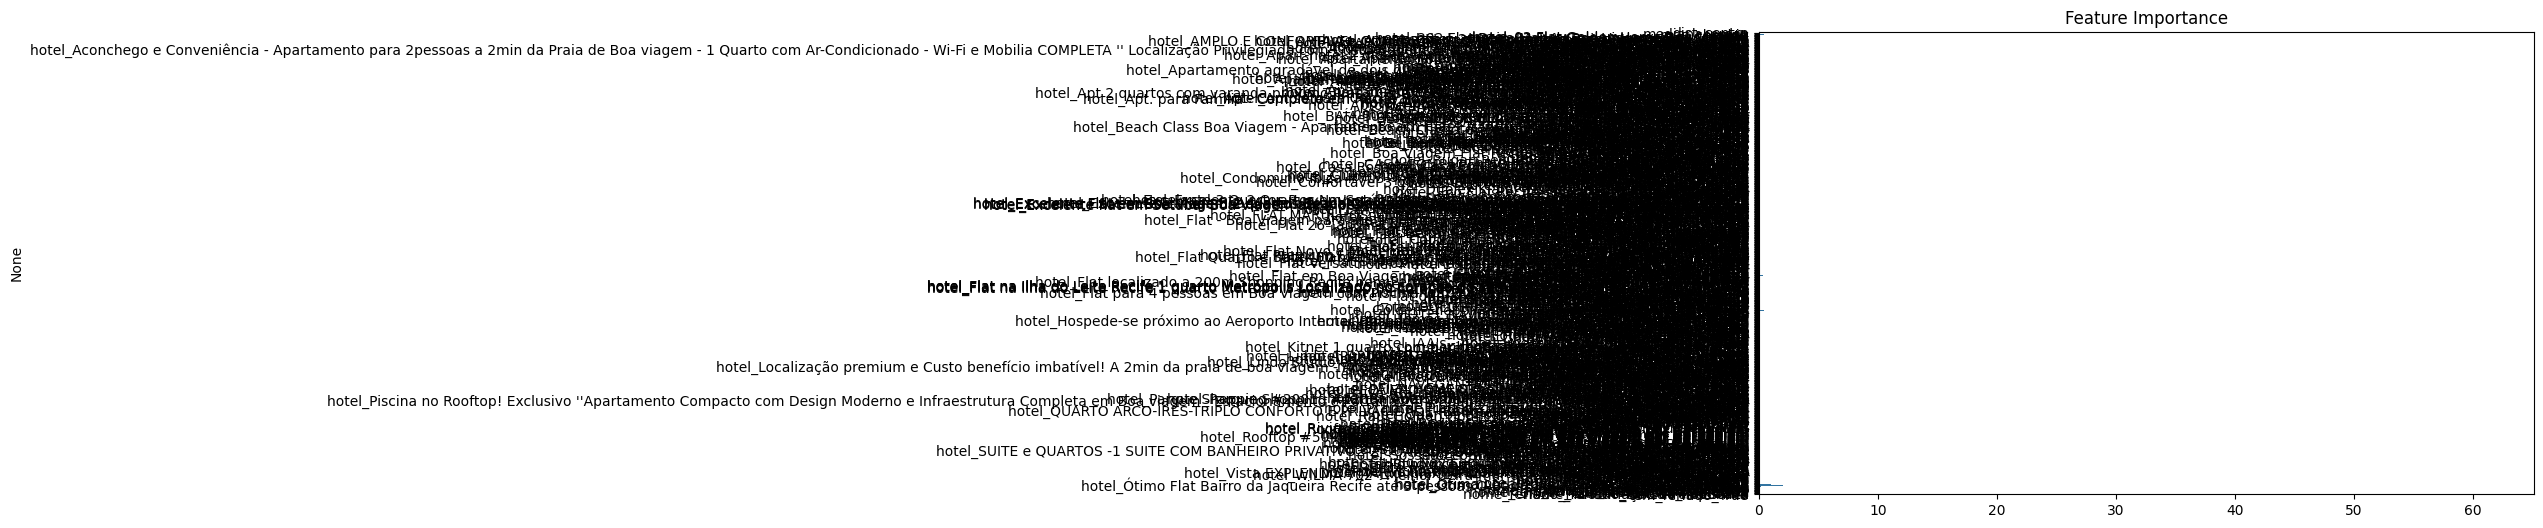

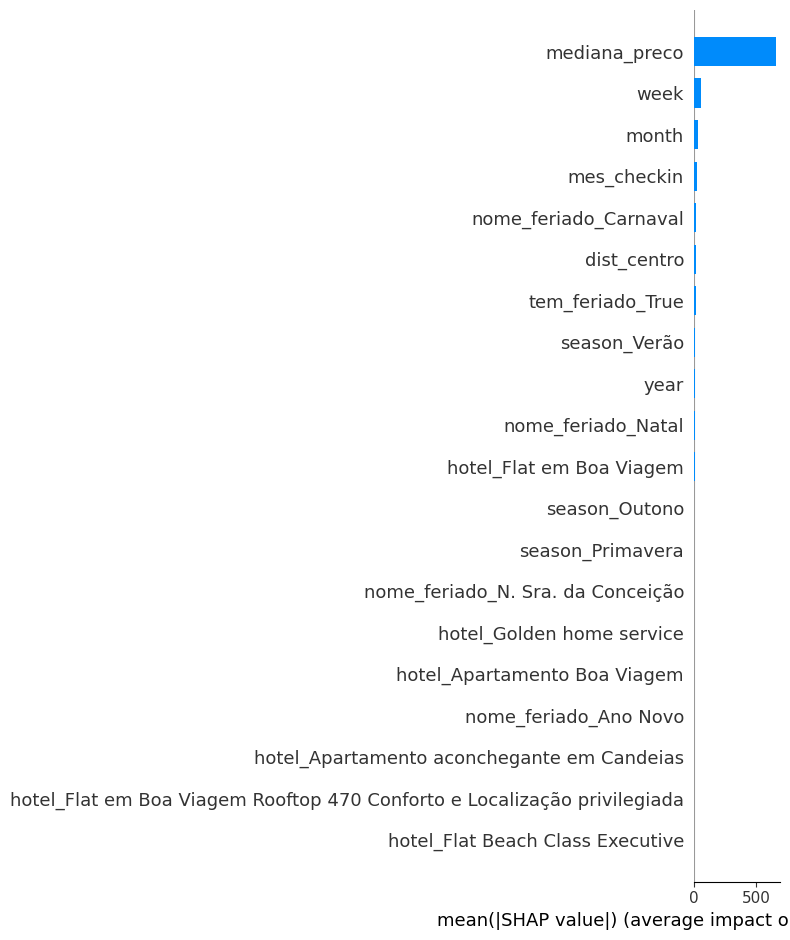

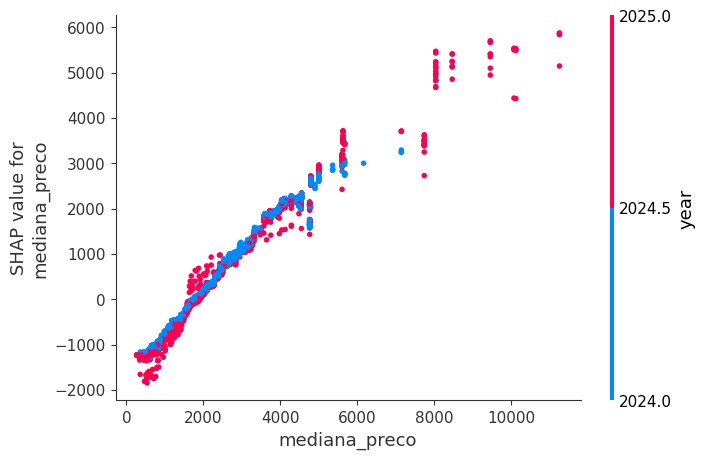

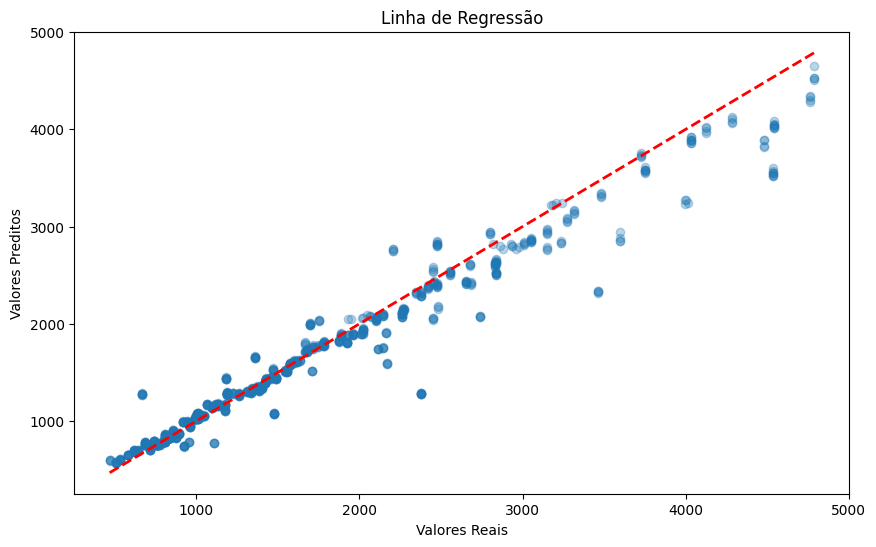

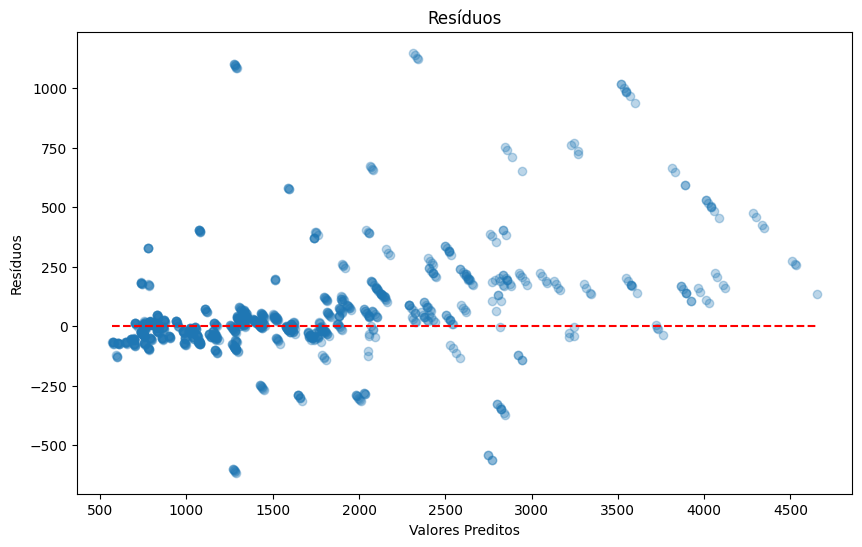

In [5]:
# Configuração do MLflow
experiment_name = "Price_Prediction_Experiment"
mlflow.set_experiment(experiment_name)
# Função de treino e avaliação com CatBoost
def train_and_evaluate_catboost(X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name="CatBoost"):
        model = CatBoostRegressor(iterations=1500, learning_rate=0.1, depth=10, random_state=42, silent=True)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, plot=True)
        
        # Avaliação do modelo no conjunto de teste
        y_pred_test = model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Avaliação do modelo no conjunto de treinamento
        y_pred_train = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        print(f'CatBoost Test RMSE: {rmse_test}')
        print(f'CatBoost Test MAE: {mae_test}')
        print(f'CatBoost Test R2: {r2_test}')
        print(f'CatBoost Train RMSE: {rmse_train}')
        print(f'CatBoost Train MAE: {mae_train}')
        print(f'CatBoost Train R2: {r2_train}')
        
        # Logando métricas no MLflow
        mlflow.log_metric("Test RMSE", rmse_test)
        mlflow.log_metric("Test MAE", mae_test)
        mlflow.log_metric("Test R2", r2_test)
        mlflow.log_metric("Train RMSE", rmse_train)
        mlflow.log_metric("Train MAE", mae_train)
        mlflow.log_metric("Train R2", r2_train)
        
        # Logando o modelo no MLflow
        mlflow.catboost.log_model(model, "CatBoost")

        # Importância das features
        feature_importance = model.get_feature_importance()
        feature_names = X_train.columns

        # Plotando a importância das features
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance, y=feature_names)
        plt.title('Feature Importance')
        plt.show()

        # Análise de Shap values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        # Summary plot
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        
        # Dependence plot para a feature mais importante
        shap.dependence_plot(np.argmax(feature_importance), shap_values, X_train)

        # Plotando a linha de regressão
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_test, alpha=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
        plt.xlabel('Valores Reais')
        plt.ylabel('Valores Preditos')
        plt.title('Linha de Regressão')
        plt.show()

        # Plotando os resíduos
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.3)
        plt.hlines(y=0, xmin=y_pred_test.min(), xmax=y_pred_test.max(), colors='r', linestyles='--')
        plt.xlabel('Valores Preditos')
        plt.ylabel('Resíduos')
        plt.title('Resíduos')
        plt.show()
        
        return model

# Treinamento e avaliação com CatBoost
best_catboost_model = train_and_evaluate_catboost(X_train, X_test, y_train, y_test)

O resultado foi diferente, o desempenho no dataset de teste foi diferente e melhor que o desempenho no treino com os mesmos hiper-parâmetros da sua melhor versão no cross-vallidation

Agora vamos tentar usar o cross-validation do CatBoost e adicionar hiper-parâmetros para reduzir o overfitting

0:	learn: 1008.6929450	test: 874.8708868	best: 874.8708868 (0)	total: 70.8ms	remaining: 1m 46s
100:	learn: 311.2474609	test: 225.0349505	best: 212.7066414 (51)	total: 4.55s	remaining: 1m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 212.7066414
bestIteration = 51

Shrink model to first 52 iterations.
CatBoost Train RMSE: 355.1493189744389
CatBoost Train MAE: 174.28177523614335
CatBoost Train R2: 0.8935722974440063
CatBoost Test RMSE: 212.70664140458175
CatBoost Test MAE: 112.53129273663164
CatBoost Test R2: 0.946661841408968


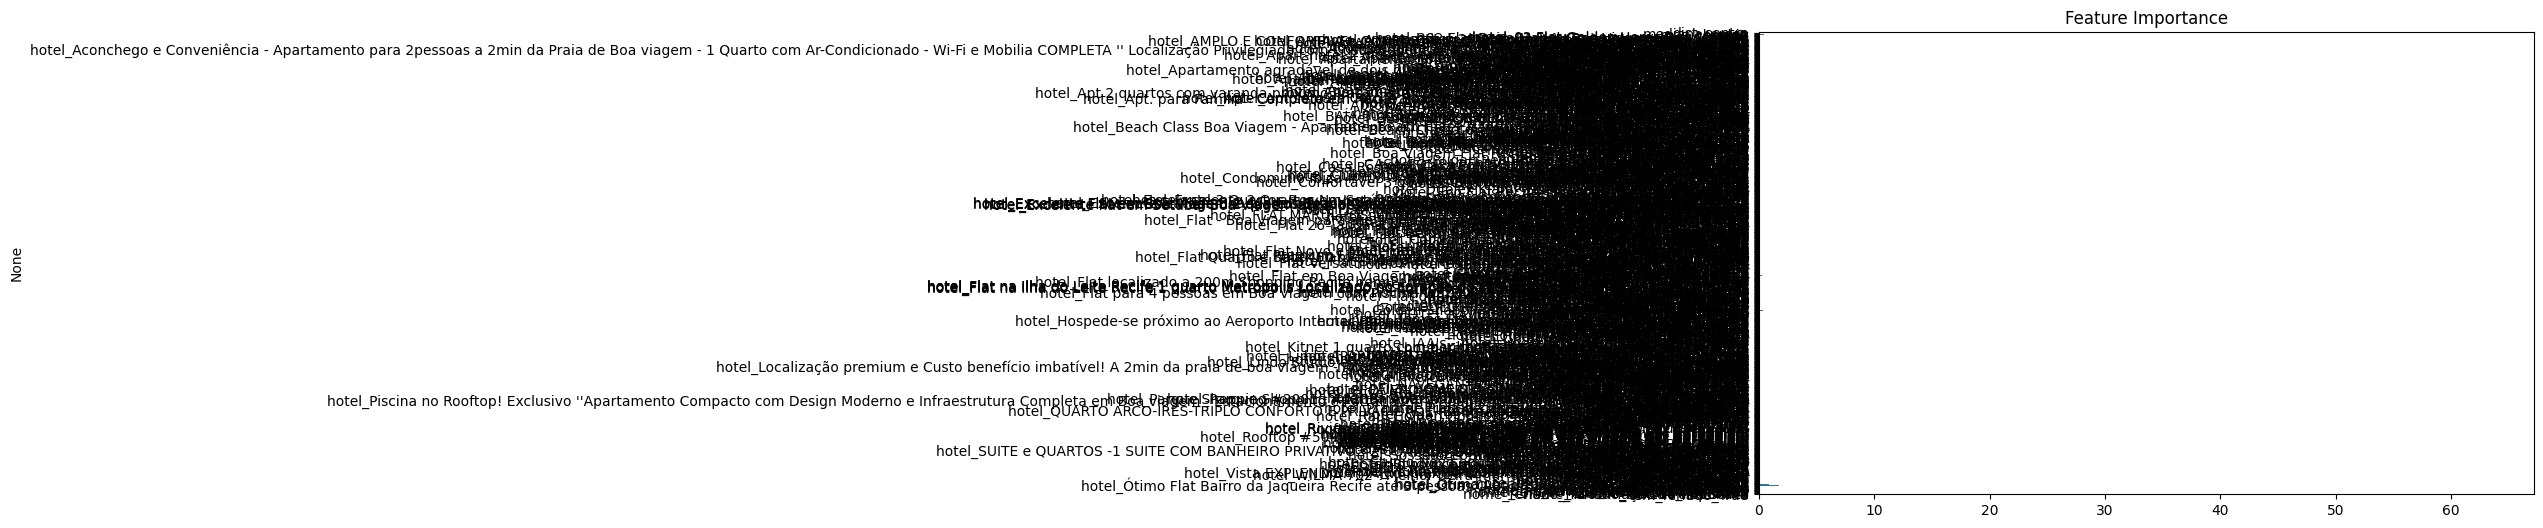

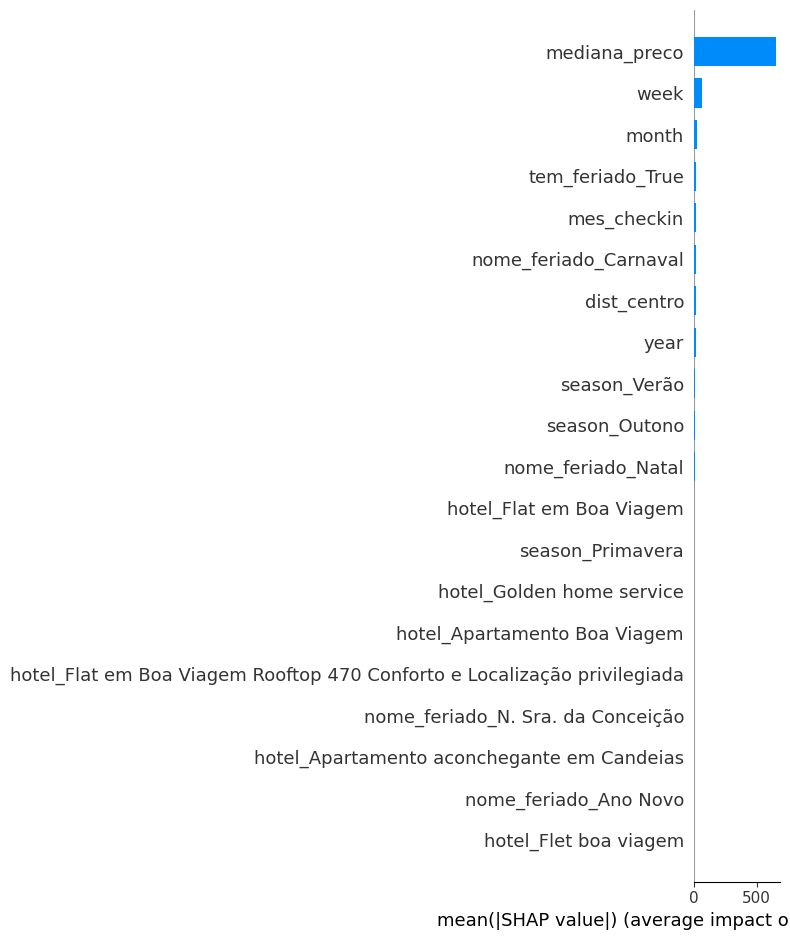

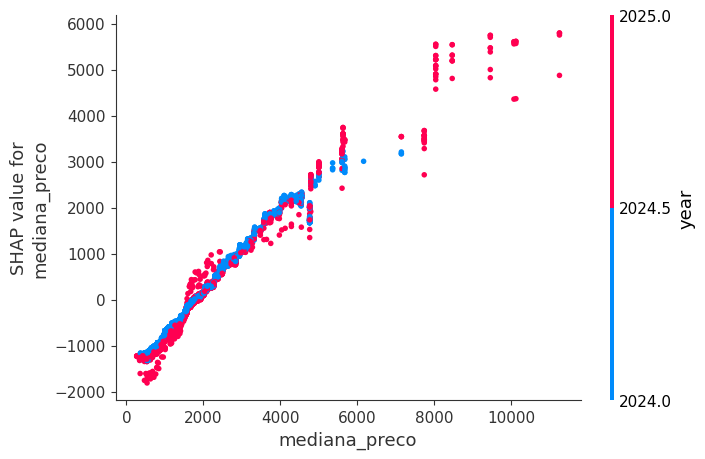

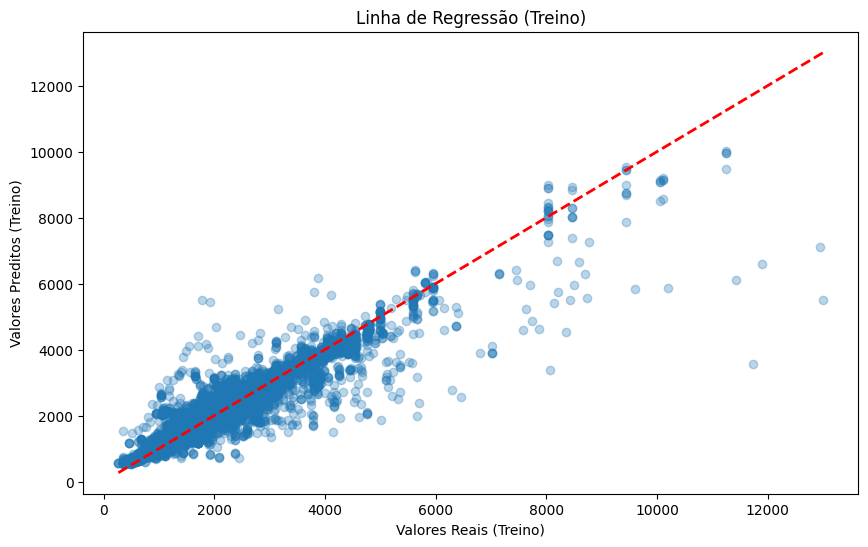

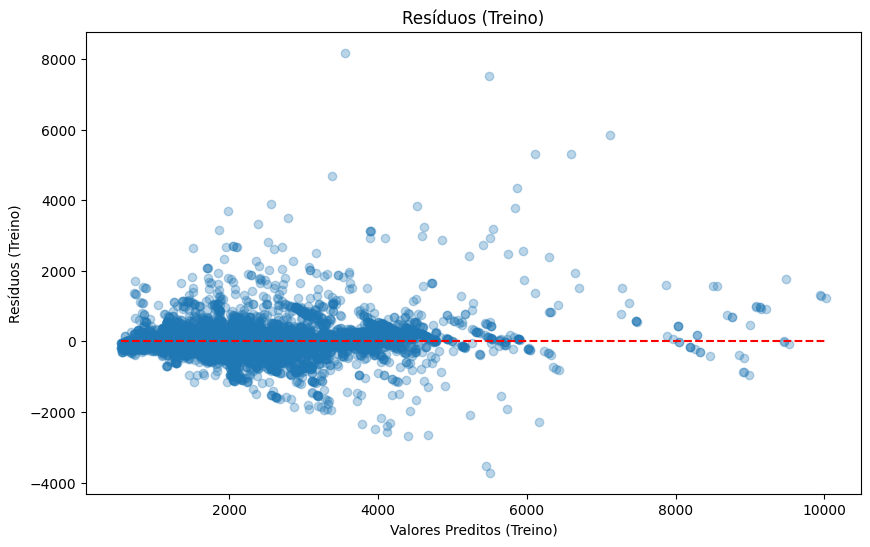

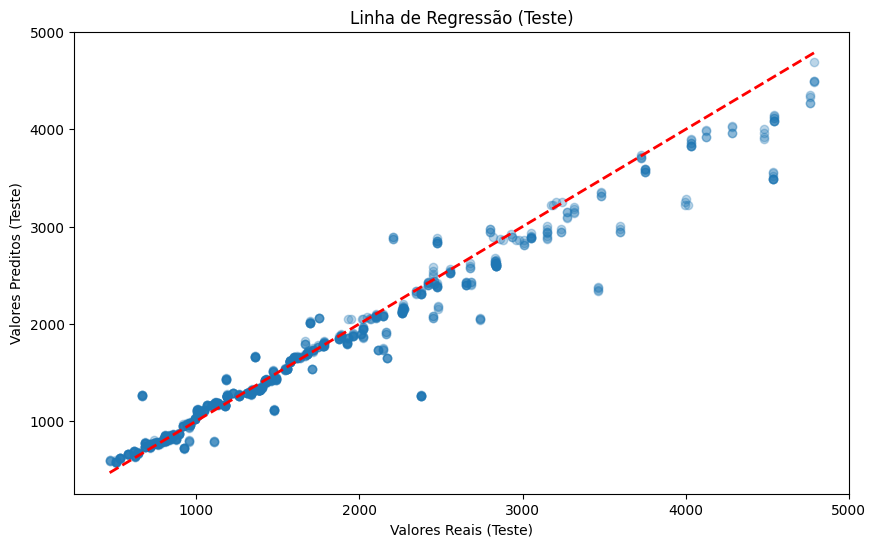

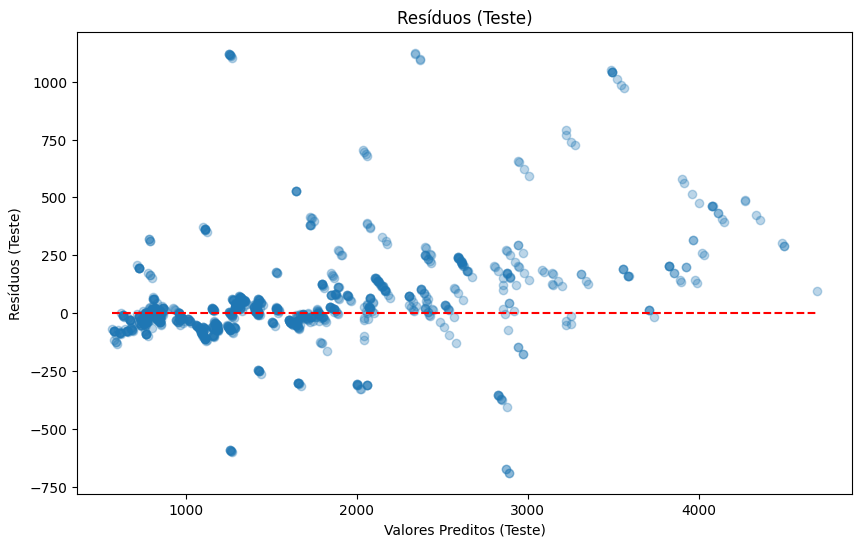

In [29]:
# Configuração do MLflow
experiment_name = "Price_Prediction_Experiment"
mlflow.set_experiment(experiment_name)

# Garantindo que X_train e X_test tenham as mesmas colunas
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Função de treino e avaliação com validação cruzada usando CatBoost
def train_and_evaluate_catboost_with_regularization(X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name="CatBoost_Regularization"):
        model = CatBoostRegressor(
            iterations=1500, 
            learning_rate=0.1, 
            depth=10, 
            l2_leaf_reg=5.0,  # Regularização L2
            bagging_temperature=2.0,  # Temperatura do bagging
            random_strength=1.0,  # Força do random
            random_state=42, 
            silent=True
        )
        
        # Configuração do Pool de dados
        train_pool = Pool(X_train, y_train)
        test_pool = Pool(X_test, y_test)
        
        # Treinamento no conjunto de treino
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=100)
        
        # Previsões no conjunto de treino e teste
        y_pred_train = model.predict(train_pool)
        y_pred_test = model.predict(test_pool)
        
        # Métricas no conjunto de treino
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        # Métricas no conjunto de teste
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        print(f'CatBoost Train RMSE: {rmse_train}')
        print(f'CatBoost Train MAE: {mae_train}')
        print(f'CatBoost Train R2: {r2_train}')
        print(f'CatBoost Test RMSE: {rmse_test}')
        print(f'CatBoost Test MAE: {mae_test}')
        print(f'CatBoost Test R2: {r2_test}')
        
        # Logando métricas no MLflow
        mlflow.log_metric("Train RMSE", rmse_train)
        mlflow.log_metric("Train MAE", mae_train)
        mlflow.log_metric("Train R2", r2_train)
        mlflow.log_metric("Test RMSE", rmse_test)
        mlflow.log_metric("Test MAE", mae_test)
        mlflow.log_metric("Test R2", r2_test)
        
        # Logando o modelo no MLflow
        mlflow.catboost.log_model(model, "CatBoost_Regularization")

        # Importância das features
        feature_importance = model.get_feature_importance()
        feature_names = X_train.columns

        # Plotando a importância das features
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance, y=feature_names)
        plt.title('Feature Importance')
        plt.show()

        # Análise de Shap values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        # Summary plot
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        
        # Dependence plot para a feature mais importante
        shap.dependence_plot(np.argmax(feature_importance), shap_values, X_train)

        # Plotando a linha de regressão no conjunto de treino
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_pred_train, alpha=0.3)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', linewidth=2)
        plt.xlabel('Valores Reais (Treino)')
        plt.ylabel('Valores Preditos (Treino)')
        plt.title('Linha de Regressão (Treino)')
        plt.show()

        # Plotando os resíduos no conjunto de treino
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_train, y_train - y_pred_train, alpha=0.3)
        plt.hlines(y=0, xmin=y_pred_train.min(), xmax=y_pred_train.max(), colors='r', linestyles='--')
        plt.xlabel('Valores Preditos (Treino)')
        plt.ylabel('Resíduos (Treino)')
        plt.title('Resíduos (Treino)')
        plt.show()

        # Plotando a linha de regressão no conjunto de teste
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_test, alpha=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
        plt.xlabel('Valores Reais (Teste)')
        plt.ylabel('Valores Preditos (Teste)')
        plt.title('Linha de Regressão (Teste)')
        plt.show()

        # Plotando os resíduos no conjunto de teste
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.3)
        plt.hlines(y=0, xmin=y_pred_test.min(), xmax=y_pred_test.max(), colors='r', linestyles='--')
        plt.xlabel('Valores Preditos (Teste)')
        plt.ylabel('Resíduos (Teste)')
        plt.title('Resíduos (Teste)')
        plt.show()

        return model

# Treinamento e avaliação com regularização usando CatBoost
best_catboost_model = train_and_evaluate_catboost_with_regularization(X_train, X_test, y_train, y_test)

Apesar de parecer um resultado inferior ao obtido anteriormente, dessa vez o overfitting do modelo foi reduzido e o desempenho no conjunto de teste mantido, deixando a perfomance do modelo mais interessante.

ExtraTree Train RMSE: 280.5719911541825
ExtraTree Train MAE: 84.19192232265802
ExtraTree Train R2: 0.9335765630960958
ExtraTree Test RMSE: 223.06605532036957
ExtraTree Test MAE: 88.18077077583987
ExtraTree Test R2: 0.9413398873668241


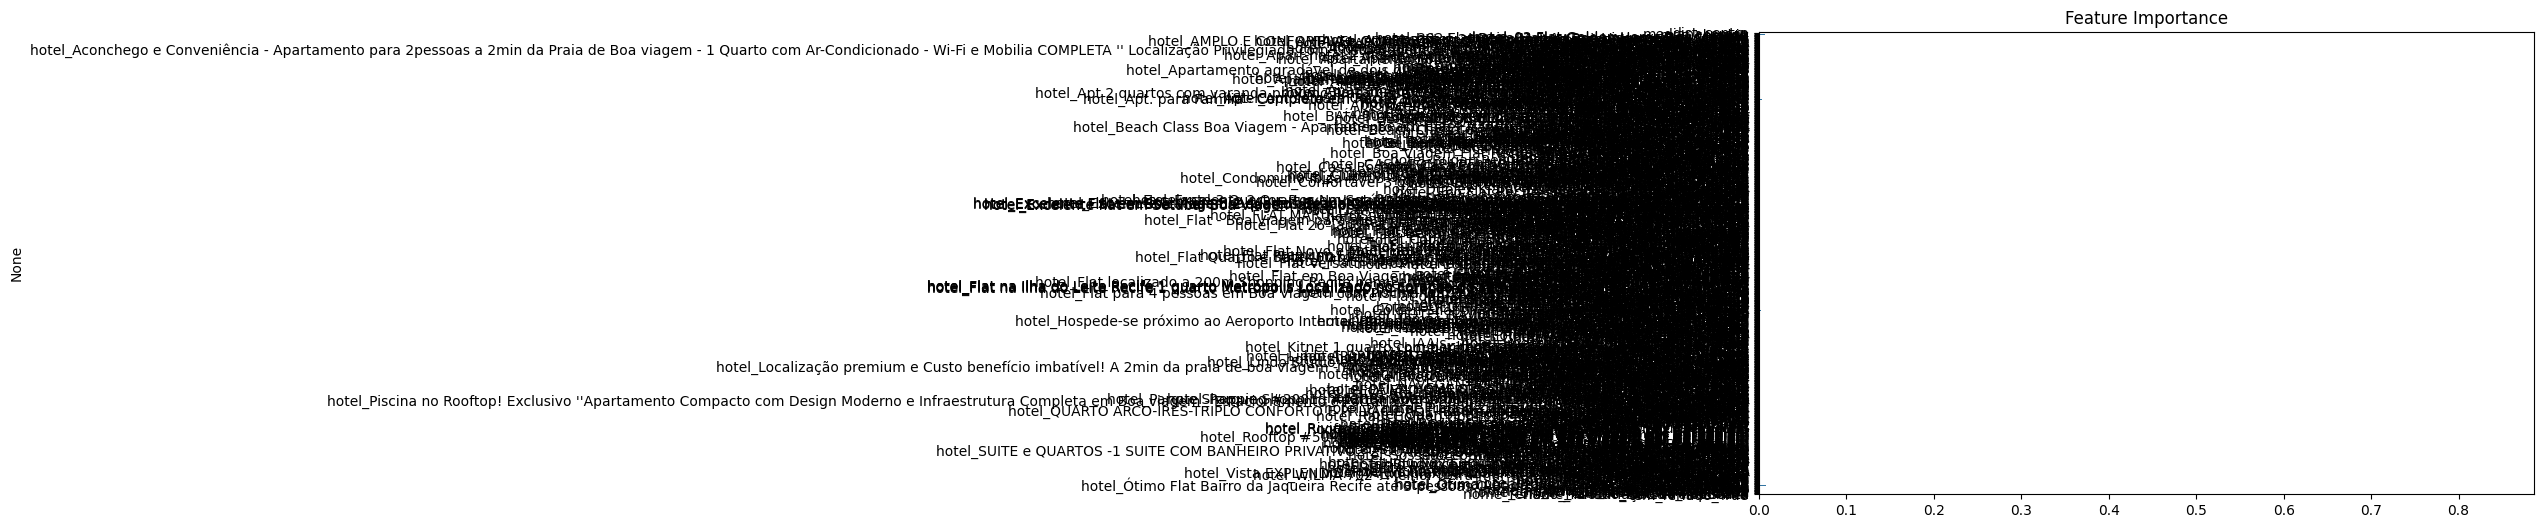

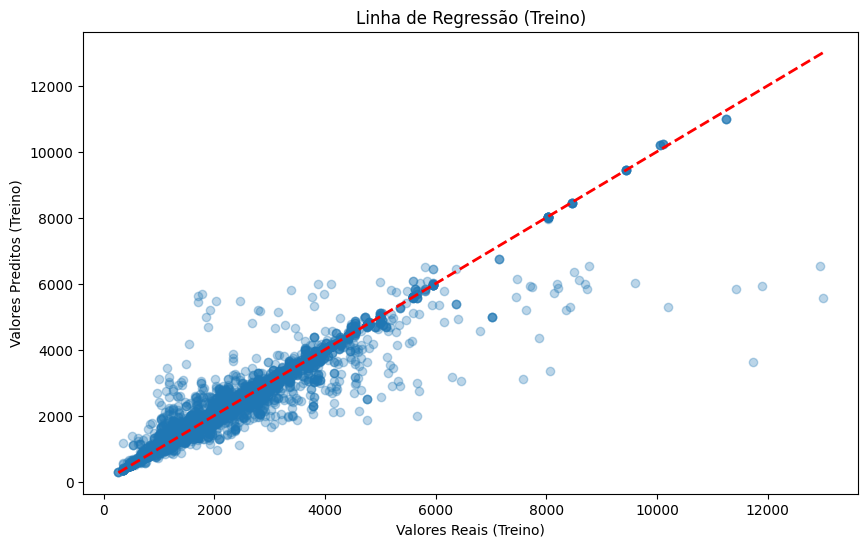

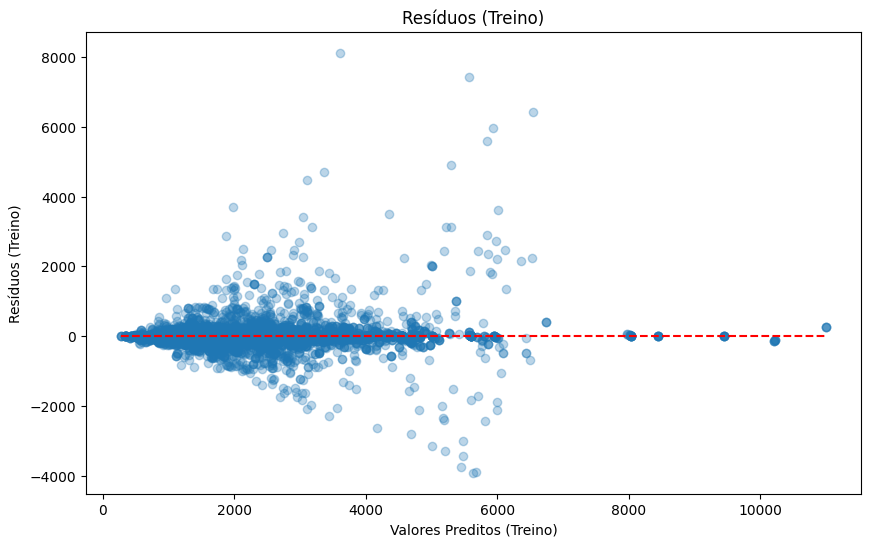

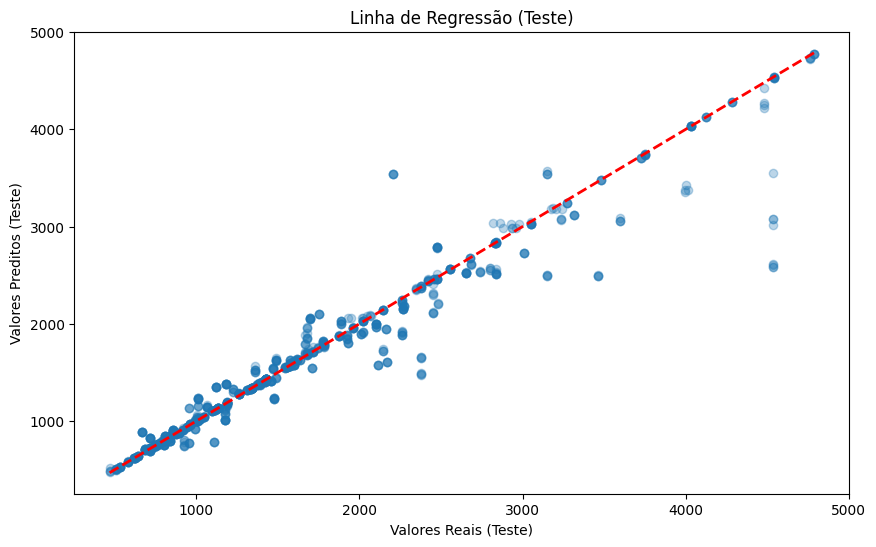

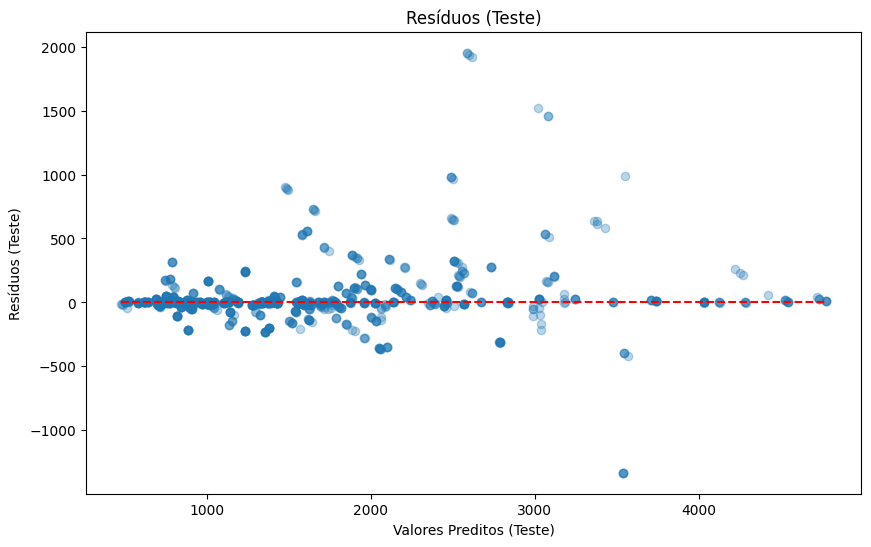

In [3]:
# Configuração do MLflow
experiment_name = "Price_Prediction_Experiment"
mlflow.set_experiment(experiment_name)

# Função de treino e avaliação com validação cruzada usando ExtraTreeRegressor
def train_and_evaluate_extratree_with_cv(X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name="ExtraTree_CV"):
        model = ExtraTreesRegressor(
            n_estimators=100,
            bootstrap=False,
            max_features=1.0,
            min_samples_leaf=4,
            min_samples_split=15,
            random_state=42
        )
        
        # Treinamento no conjunto de treino
        model.fit(X_train, y_train)
        
        # Previsões no conjunto de treino e teste
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Métricas no conjunto de treino
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        
        # Métricas no conjunto de teste
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        print(f'ExtraTree Train RMSE: {rmse_train}')
        print(f'ExtraTree Train MAE: {mae_train}')
        print(f'ExtraTree Train R2: {r2_train}')
        print(f'ExtraTree Test RMSE: {rmse_test}')
        print(f'ExtraTree Test MAE: {mae_test}')
        print(f'ExtraTree Test R2: {r2_test}')
        
        # Logando métricas no MLflow
        mlflow.log_metric("Train RMSE", rmse_train)
        mlflow.log_metric("Train MAE", mae_train)
        mlflow.log_metric("Train R2", r2_train)
        mlflow.log_metric("Test RMSE", rmse_test)
        mlflow.log_metric("Test MAE", mae_test)
        mlflow.log_metric("Test R2", r2_test)
        
        # Logando o modelo no MLflow
        mlflow.sklearn.log_model(model, "ExtraTree_CV")

        # Importância das features
        feature_importance = model.feature_importances_
        feature_names = X_train.columns

        # Plotando a importância das features
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance, y=feature_names)
        plt.title('Feature Importance')
        plt.show()

        # # Análise de Shap values
        # explainer = shap.TreeExplainer(model)
        # shap_values = explainer.shap_values(X_train)

        # # Summary plot
        # shap.summary_plot(shap_values, X_train, plot_type="bar")
        
        # # Dependence plot para a feature mais importante
        # shap.dependence_plot(np.argmax(feature_importance), shap_values, X_train)

        # Plotando a linha de regressão no conjunto de treino
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_pred_train, alpha=0.3)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', linewidth=2)
        plt.xlabel('Valores Reais (Treino)')
        plt.ylabel('Valores Preditos (Treino)')
        plt.title('Linha de Regressão (Treino)')
        plt.show()

        # Plotando os resíduos no conjunto de treino
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_train, y_train - y_pred_train, alpha=0.3)
        plt.hlines(y=0, xmin=y_pred_train.min(), xmax=y_pred_train.max(), colors='r', linestyles='--')
        plt.xlabel('Valores Preditos (Treino)')
        plt.ylabel('Resíduos (Treino)')
        plt.title('Resíduos (Treino)')
        plt.show()
        
        # Plotando a linha de regressão no conjunto de teste
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_test, alpha=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
        plt.xlabel('Valores Reais (Teste)')
        plt.ylabel('Valores Preditos (Teste)')
        plt.title('Linha de Regressão (Teste)')
        plt.show()

        # Plotando os resíduos no conjunto de teste
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.3)
        plt.hlines(y=0, xmin=y_pred_test.min(), xmax=y_pred_test.max(), colors='r', linestyles='--')
        plt.xlabel('Valores Preditos (Teste)')
        plt.ylabel('Resíduos (Teste)')
        plt.title('Resíduos (Teste)')
        plt.show()
        
        return model

# Divisão dos dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento e avaliação com validação cruzada usando ExtraTreeRegressor
best_extratree_model = train_and_evaluate_extratree_with_cv(X_train, X_test, y_train, y_test)

Utilizando o ExtraTree obtemos o mesmo resultado do automl, se tornando um modelo super viável por possuir um desempenho rápido e obter um bom resultado sem overfitting.

## K-Means

Vamos agora aplicar o K-means para melhor entendimento dos dados

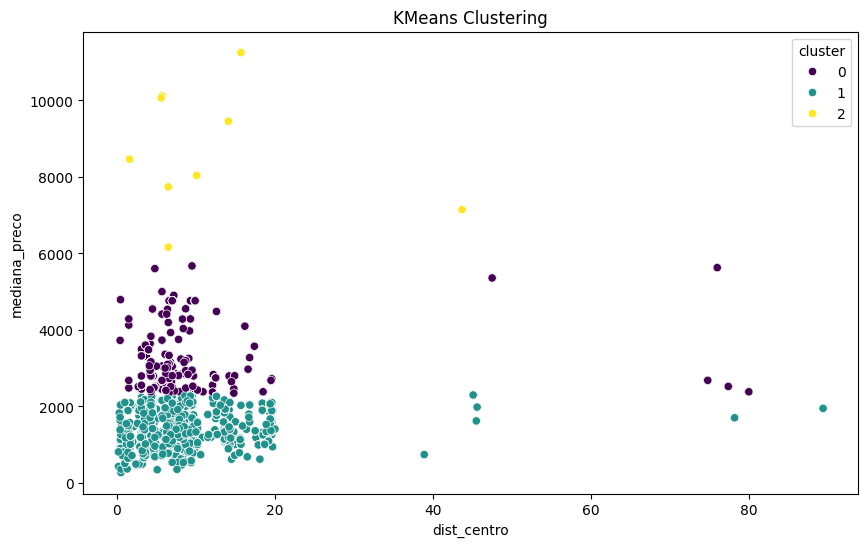

In [15]:
# Função para aplicar KMeans e visualizar os clusters
def apply_kmeans_clustering(X, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    X['cluster'] = kmeans.fit_predict(X)
    
    # Visualização dos clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue='cluster', data=X, palette='viridis')
    plt.title('KMeans Clustering')
    plt.show()

# Aplicação do KMeans no dataset de treino
apply_kmeans_clustering(X_train)

O K-means comparou a coluna mediana_preco com a coluna dist_centro gerando 3 grupos distintos. Sugere que existem diferentes níveis de hotéis pelo preço, sendo os pontos verdes os hotéis mais "econômicos", os roxos hotéis mais caros e os amarelos hotéis mais luxuosos e muito mais caros.

Agora vamos testar o modelo prevendo o preço de hotéis em datas específicas

#### CatBoost

In [31]:
# Previsão de novos preços com o CatBoost
nova_data = pd.DataFrame({
    'hotel': ['Madalena', 'Madalena', 'Madalena'],
    'yeaar': [2025, 2025, 2025],
    'month': [1, 3, 6],
    'week': [1, 9, 22],
    'season': ['Verão', 'Outono', 'Inverno'],
    'dist_centro': [5, 5, 5],
    'mes_checkin': [1, 3, 6],
    'tem_feriado': [True, True, False],
    'nome_feriado': ['Ano Novo', 'Carnaval', None],
    'mediana_preco': [1000, 1000, 1000]
})
nova_data = pd.get_dummies(nova_data, columns=['hotel'], drop_first=True)
nova_data = nova_data.reindex(columns=X_train.columns, fill_value=0)
precos_previstos = best_catboost_model.predict(nova_data)
print(precos_previstos)

[1276.55809933 1241.25312657 1001.52701719]


#### ExtraTree

In [4]:
# Previsão de novos preços com o CatBoost
nova_data = pd.DataFrame({
    'hotel': ['Madalena', 'Madalena', 'Madalena'],
    'yeaar': [2025, 2025, 2025],
    'month': [1, 3, 6],
    'week': [1, 9, 22],
    'season': ['Verão', 'Outono', 'Inverno'],
    'dist_centro': [5, 5, 5],
    'mes_checkin': [1, 3, 6],
    'tem_feriado': [True, True, False],
    'nome_feriado': ['Ano Novo', 'Carnaval', None],
    'mediana_preco': [1000, 1000, 1000]
})
nova_data = pd.get_dummies(nova_data, columns=['hotel'], drop_first=True)
nova_data = nova_data.reindex(columns=X_train.columns, fill_value=0)
precos_previstos = best_extratree_model.predict(nova_data)
print(precos_previstos)

[1084.70527553 1045.14823249 1022.26194797]
